id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64
Numerical data: ['id', 'age', 'avg_glucose_level', 'bmi']
Categorical data: ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
              precision    recall  f1-score   support

           0       0.96      0.90      0.93       975
           1       0.90      0.96      0.93       970

    accuracy                           0.93      1945
   macro avg       0.93      0.93      0.93      1945
weighted avg       0.93      0.93      0.93      1945



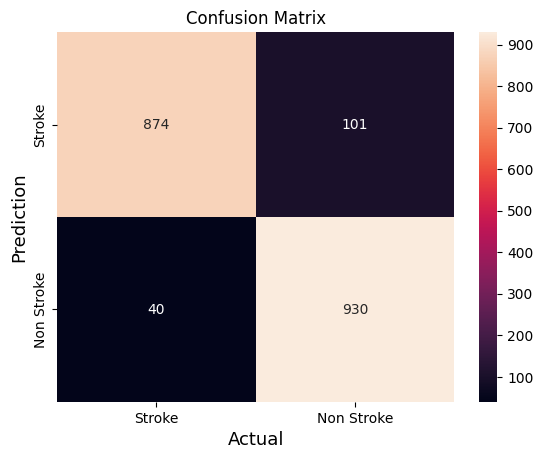

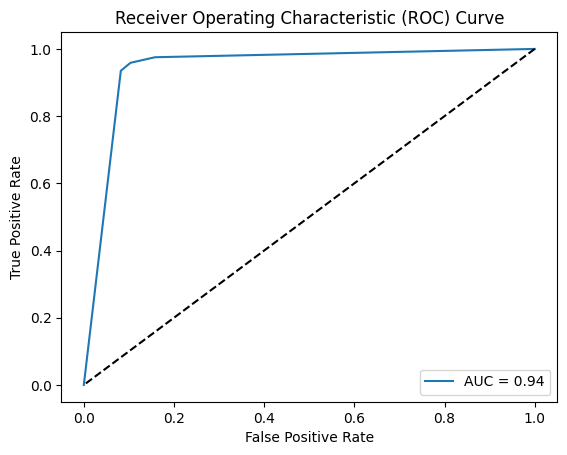

Specificity :  0.8964102564102564
Sensitivity :  0.9587628865979382


In [ ]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif

import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import numpy as np
import pandas as pd
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.decomposition import PCA
from scipy.interpolate import interp1d
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report

# Load stroke dataset
df = pd.read_csv("healthcare-dataset-stroke-data.csv")

# Check for missing values in the dataset
print(df.isnull().sum())

mean_value = df['bmi'].mean()
df['bmi'].fillna(value = mean_value , inplace= True)

numeric_data=df.loc[:,df.nunique() > 5]
cols = [col for col in df.columns if col not in numeric_data]
categorical_data=df[cols].drop('stroke',axis=1)
numeric_data=pd.DataFrame(numeric_data)
categorical_data=pd.DataFrame(categorical_data)
print(f'Numerical data: {list(numeric_data)}')
print(f'Categorical data: {list(categorical_data)}')


#sstandardization

num_cols=numeric_data.columns.to_list()
sc = StandardScaler()
df[num_cols] = sc.fit_transform(df[num_cols])

#df_interp.head()

#label encoding

le = LabelEncoder()
object_col = [col for col in df.columns if df[col].dtype == 'object']
for col in object_col:
    df[col] = le.fit_transform(df[col])


X= df.drop(['stroke'],axis=1)
y= df['stroke']

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X, y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train_smote, y_train_smote, test_size=0.2, random_state=42)


# Apply PCA for dimensionality reduction
pca = PCA(n_components=7)  # Adjust number of components as needed
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Define base classifiers
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
gb_classifier = XGBClassifier(random_state=42)

# Train the base classifiers
rf_classifier.fit(X_train_pca, y_train)
gb_classifier.fit(X_train_pca, y_train)

# Generate predictions from base classifiers
rf_pred = rf_classifier.predict(X_train_pca)
gb_pred = gb_classifier.predict(X_train_pca)

# Create a new feature matrix containing predictions of base classifiers
X_train_stacked = pd.DataFrame({'RF_Pred': rf_pred, 'GB_Pred': gb_pred})

# Define a meta-classifier
#meta_classifier = LogisticRegression()
#meta_classifier =DecisionTreeClassifier()
meta_classifier =LogisticRegression()

# Train the meta-classifier using the stacked features
meta_classifier.fit(X_train_stacked, y_train)

# Generate predictions from base classifiers on the test set
rf_pred_test = rf_classifier.predict(X_test_pca)
gb_pred_test = gb_classifier.predict(X_test_pca)

# Create a new feature matrix containing predictions of base classifiers for the test set
X_test_stacked = pd.DataFrame({'RF_Pred': rf_pred_test, 'GB_Pred': gb_pred_test})

y_pred=meta_classifier.predict(X_test_stacked)

# print classification report
print(classification_report(y_test,y_pred))

# compute the confusion matrix
cm1 = confusion_matrix(y_test,y_pred)

#Plot the confusion matrix.
sns.heatmap(cm1,
			annot=True,
			fmt='g',
			xticklabels=['Stroke', 'Non Stroke'],
			yticklabels=['Stroke', 'Non Stroke'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=12)
plt.show()

y_scores = meta_classifier.predict_proba(X_test_stacked)[:, 1]  # Get the predicted probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([1, 0], [1, 0], 'k--')  # Diagonal line for random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

#Calculate specificity & sensitivity
specificity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Specificity : ', specificity1 )

sensitivity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])

print('Sensitivity : ', sensitivity1)